In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import itertools
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
import sklearn

# Import air quality


In [2]:
df_airquality = pd.read_csv('airquality.csv',usecols = ['Ozone','Solar.R','Wind','Temp'])
df_airquality.head()

,Ozone,Solar.R,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
4,NaN,NaN,14.3,56


**Adding 'TWcp'Column and 'TWrat' Column to the df_airquality**

In [3]:
df_airquality['TWcp'] = np.round(df_airquality['Temp']* df_airquality['Wind'],2)
df_airquality['TWrat'] = np.round(df_airquality['Temp']/ df_airquality['Wind'],2)

df_airquality = df_airquality.dropna()

df_airquality.isna().any()

Ozone      False
Solar.R    False
Wind       False
Temp       False
TWcp       False
TWrat      False
dtype: bool

# Report the variables in the best model of each size

**steps:** 

**fit LinearRegression() , call sfs() for each size tor report the best variables**

In [4]:
# # Call multiple linear regression model
ozonReg = LinearRegression()
sfs1 = sfs(ozonReg, k_features=1, forward=True, verbose=0,
           scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(df_airquality[['Solar.R', 'Wind', 'Temp', 'TWcp', 'TWrat']],
                df_airquality['Ozone'])

sfs2 = sfs(ozonReg, k_features=2, forward=True, verbose=0,
           scoring='neg_mean_squared_error')
sfs2 = sfs2.fit(df_airquality[['Solar.R', 'Wind', 'Temp', 'TWcp', 'TWrat']],
                df_airquality['Ozone'])


sfs3 = sfs(ozonReg, k_features=3, forward=True, verbose=0,
           scoring='neg_mean_squared_error')
sfs3 = sfs3.fit(df_airquality[['Solar.R', 'Wind', 'Temp', 'TWcp', 'TWrat']],
                df_airquality['Ozone'])



sfs4 = sfs(ozonReg, k_features=4, forward=True, verbose=0,
           scoring='neg_mean_squared_error')
sfs4 = sfs4.fit(df_airquality[['Solar.R', 'Wind', 'Temp', 'TWcp', 'TWrat']],
                df_airquality['Ozone'])

# 1-a : Report the variables in the best  forward models of each size


In [5]:
print('\n\nThe answer of 1-a : Report the variables in the best models of each size\n\n',
      50 * "--")
print('forward _model1_features:',list(sfs1.k_feature_names_),"\n")
print('forward _ model2_features:',list(sfs2.k_feature_names_),"\n")
print('forward _model3_features:',list(sfs3.k_feature_names_),"\n")
print('forward _model4_features:',list(sfs4.k_feature_names_))



The answer of 1-a : Report the variables in the best models of each size

 ----------------------------------------------------------------------------------------------------
forward _model1_features: ['Temp'] 

forward _ model2_features: ['Temp', 'TWcp'] 

forward _model3_features: ['Wind', 'Temp', 'TWcp'] 

forward _model4_features: ['Solar.R', 'Wind', 'Temp', 'TWcp']


# 1-b)Fit statmodel in the best forward models of each size to report BIC  of each models

In [6]:
x1 = sm.add_constant(df_airquality[['Temp']])    
 
x2= sm.add_constant(df_airquality[['Temp','TWcp']]) 

x3= sm.add_constant(df_airquality[['Wind','Temp','TWcp']]) 

x4= sm.add_constant(df_airquality[['Solar.R','Wind','Temp','TWcp']]) 

model1_reg = sm.OLS(df_airquality[['Ozone']],x1).fit()

model2_reg = sm.OLS(df_airquality[['Ozone']],x2).fit()

model3_reg = sm.OLS(df_airquality[['Ozone']],x3).fit()

model4_reg = sm.OLS(df_airquality[['Ozone']],x4).fit()

C:\Users\mzand\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [7]:
print('bic of model1 is :' ,np.round(model1_reg.bic,2),"\n" )
print('bic of model2 is :' ,np.round(model2_reg.bic,2),"\n" )
print('bic of model3 is :' ,np.round(model3_reg.bic,2),"\n" )
print('bic of model4 is :' ,np.round(model4_reg.bic,2) )


bic of model1 is : 1027.19 

bic of model2 is : 1004.16 

bic of model3 is : 998.88 

bic of model4 is : 994.15


## 1-c) Identify the best model : 

**Based in the  smallest bic ,the 4th model which contain**

**['Solar.R','Wind','Temp','TWcp'] features is the best one.**

# 2-Best model based in hybrid stepwise algoritm


**Define a function which combine forward and backward methods**

In [8]:
def hybrid_func(df, feature_number, response_name):
    '''
    This function get the dataframe , number of features
    and response column name (as string)
    and process the forward and backward methods in hybrid method.
    
    inputs :
        df : data frame of features and response
        feature_number: number of features which we want to select
        respponse_name : Name of the response column in data frame.
    
    '''
    df_func = df.copy()
    y = df_func[[response_name]]
    df_func.drop(response_name, axis= 'columns', inplace= True)
    x = df_func
    
    func_reg = LinearRegression()
    
    func_sfs_f = sfs(func_reg, k_features=feature_number +1, 
                     forward=True, verbose=0, scoring='neg_mean_squared_error')
    func_sfs_f = func_sfs_f.fit(x,y)
    
    columns_from_forward = df[list(func_sfs_f.k_feature_names_)]
    
    func_sfs_b = sfs(func_reg, k_features=feature_number,
                     forward=False, verbose=0, scoring='neg_mean_squared_error')
    func_sfs_b = func_sfs_b.fit(columns_from_forward, y)
    
    return func_sfs_b.k_feature_names_

# 2: Report the variables in the best  hybrid models of each size


In [9]:
print('hybrid _model1_features' ,hybrid_func(df_airquality, 1, 'Ozone'))
print('hybrid _model2_features', hybrid_func(df_airquality, 2, 'Ozone'))
print('hybrid _model3_features', hybrid_func(df_airquality, 3, 'Ozone'))
print('hybrid _model4_features', hybrid_func(df_airquality, 4, 'Ozone'))

hybrid _model1_features ('Temp',)
hybrid _model2_features ('Temp', 'TWcp')
hybrid _model3_features ('Wind', 'Temp', 'TWcp')
hybrid _model4_features ('Solar.R', 'Wind', 'Temp', 'TWcp')


**In this sample as the variables in the best  hybrid models of each size are same as**

**forward models so the result about the best model based in bic is similar to forward model** 

**and ,the 4th model which contain ['Solar.R','Wind','Temp','TWcp'] features is the best one.**

## The answer of parts, 3-a , 3-b , 3-c , are reported according to below codes

In [10]:

rcv = RepeatedKFold(n_splits= 10, n_repeats= 1, random_state= 2928893)


hybrid_model1_feature= df_airquality[list(hybrid_func(df_airquality, 1, 'Ozone'))]
hybrid_model2_feature = df_airquality[list(hybrid_func(df_airquality, 2, 'Ozone'))]
hybrid_model3_feature = df_airquality[list(hybrid_func(df_airquality, 3, 'Ozone'))]
hybrid_model4_feature = df_airquality[list(hybrid_func(df_airquality, 4, 'Ozone'))]
response = df_airquality[['Ozone']]

score_cv_hybrid_model1 = cross_val_score(LinearRegression(), hybrid_model1_feature ,
                                         response, scoring= 'neg_mean_squared_error', cv= rcv)

score_cv_hybrid_model2 = cross_val_score(LinearRegression(), hybrid_model2_feature ,
                                         response, scoring= 'neg_mean_squared_error', cv= rcv)

score_cv_hybrid_model3 = cross_val_score(LinearRegression(), hybrid_model3_feature ,
                                         response, scoring= 'neg_mean_squared_error', cv= rcv)

score_cv_hybrid_model4 = cross_val_score(LinearRegression(), hybrid_model4_feature ,
                                         response, scoring= 'neg_mean_squared_error', cv= rcv)

In [11]:
print('Mean Squared Predict Error for model1 is : %.2f' %-score_cv_hybrid_model1.mean())
print('Mean Squared Predict Error for model2 is : %.2f' %-score_cv_hybrid_model2.mean())
print('Mean Squared Predict Error formodel3 is : %.2f' %-score_cv_hybrid_model3.mean())
print('Mean Squared Predict Error for model4 is : %.2f' %-score_cv_hybrid_model4.mean())


Mean Squared Predict Error for model1 is : 585.58
Mean Squared Predict Error for model2 is : 462.51
Mean Squared Predict Error formodel3 is : 432.37
Mean Squared Predict Error for model4 is : 407.62


# box plots

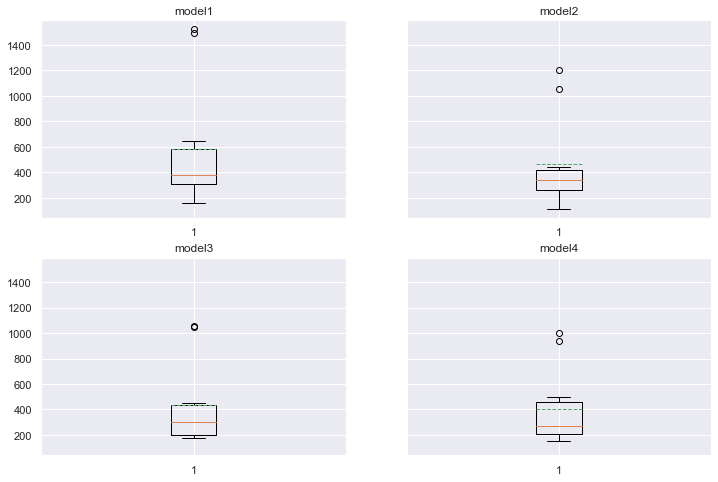

In [12]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharey = True)

ax[0,0].boxplot(-score_cv_hybrid_model1, meanline= True, showmeans= True)
ax[0,0].set_title('model1')

ax[0,1].boxplot(-score_cv_hybrid_model2,  meanline= True, showmeans= True)
ax[0,1].set_title('model2')


ax[1,0].boxplot(-score_cv_hybrid_model3, meanline= True, showmeans= True)
ax[1,0].set_title('model3')

ax[1,1].boxplot(-score_cv_hybrid_model4, meanline= True, showmeans= True)
ax[1,1].set_title('model4')

plt.show()

# zoom in Boxplots model 3 and model 4

Text(0.5, 1.0, 'model4')

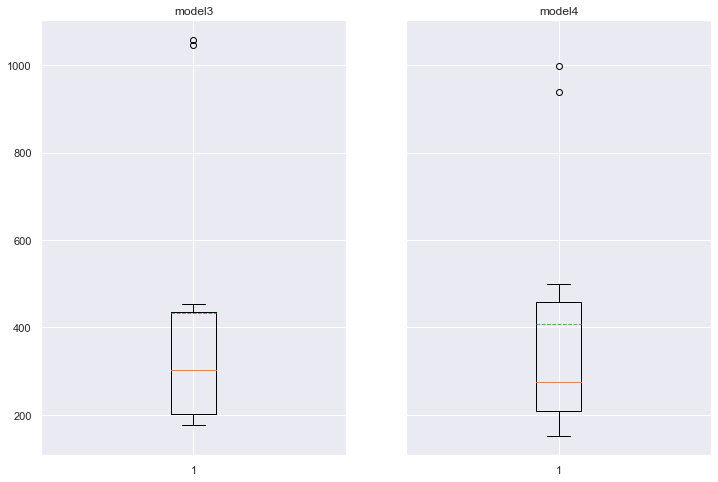

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,8), sharey = True)
ax[0].boxplot(-score_cv_hybrid_model3, meanline= True, showmeans= True)
ax[0].set_title('model3')
#ax[1,0].annotate('MSPE = 584.85', xy = (0.5, 2500))

ax[1].boxplot(-score_cv_hybrid_model4, meanline= True, showmeans= True)
ax[1].set_title('model4')
#ax[1,1].annotate('MSPE = 1362.91', xy = (0.5, 2500))

# 3-d)According to Minimum MSPE and 


# boxplot the 4th model is the best


## that its MSPE is 249.56 and this the smallest


## MSPE in comparing to other models

# e)Report the seprate MSPEs from 

# each folds and MSPEs for full data

In [14]:
print(f"Squared Predict Error for model1 is:\n {-score_cv_hybrid_model1},\n\n")
print(f"Squared Predict Error for model2 is:\n {-score_cv_hybrid_model2}\n\n")
print(f"Squared Predict Error for model3 is:\n {-score_cv_hybrid_model3}\n\n")
print(f"Squared Predict Error for model4 is:\n {-score_cv_hybrid_model4}\n\n")

Squared Predict Error for model1 is:
 [ 338.94810032  378.2086315  1493.77378444  383.63699706  406.38800027
  643.83565718 1521.45720828  296.21083051  160.8064446   232.49112921],


Squared Predict Error for model2 is:
 [ 321.33182856  272.2522128  1052.64776963  252.42135325  364.05584024
  440.26290899 1206.01328709  354.10405434  251.14083969  110.85223162]


Squared Predict Error for model3 is:
 [ 263.73716241  341.39649014 1045.76413767  190.09811612  376.78718963
  453.31090148 1057.57978407  238.5252552   180.58133459  175.95350961]


Squared Predict Error for model4 is:
 [197.91512069 286.71196058 999.48957935 242.20370119 331.31510107
 499.69237293 939.32094704 152.45742361 261.18336512 165.89271419]




In [15]:
result_df = pd.DataFrame({'model_1_MSPE':-score_cv_hybrid_model2, 
                          'model_2_MSPE': -score_cv_hybrid_model2,
                         'model_3_MSPE': -score_cv_hybrid_model3,
                          'model_4_MSPE': -score_cv_hybrid_model4 })
result_df

,model_1_MSPE,model_2_MSPE,model_3_MSPE,model_4_MSPE
0,321.331829,321.331829,263.737162,197.915121
1,272.252213,272.252213,341.396490,286.711961
2,1052.647770,1052.647770,1045.764138,999.489579
3,252.421353,252.421353,190.098116,242.203701
4,364.055840,364.055840,376.787190,331.315101
5,440.262909,440.262909,453.310901,499.692373
6,1206.013287,1206.013287,1057.579784,939.320947
7,354.104054,354.104054,238.525255,152.457424
8,251.140840,251.140840,180.581335,261.183365
9,110.852232,110.852232,175.953510,165.892714
